In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import datetime as dt
from dateutil.relativedelta import relativedelta
import sys
import pyodbc
import sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt

In [68]:
metal = "Platinum"

In [59]:
# inputs = pd.read_csv('../data/csv/Gold_Data.csv')
# training_set = inputs[['Money Manager Shorts', 'Money Manager Longs', 'Ten_Yr_Futures_Settle', 'USD_Change']]
# training_set_y = inputs[['Gold_Settle']]

In [75]:
df = pd.read_csv(f"../data/csv/{metal}_Data.csv",index_col="Business_Week")
df = df.drop(df.columns[0],axis=1)
df = df.drop(df.columns[9],axis=1)
df[f"{metal}_Settle"] = df[f"{metal}_Settle"].fillna(method='bfill')
df = df.dropna(axis=1)
# Makes graphs easier to interpret and match up. This is unimportent for
# this model.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.reset_index(drop=True)
for i in range(len(df["Date"])):
    if df["Date"][i].weekday() != 1:
#         print(df["Date"][i])
        try:
            df.at[i,"Date"] = df["Date"][i-1]+timedelta(days=7)
#             print(df["Date"][i])
#             print(df["Date"][i].weekday())
        except:
            df.at[i,"Date"] = df["Date"][i+1]-timedelta(days=7)
# print(df.iloc[29,:])
df.set_index("Date",inplace=True)
df = df.asfreq("W-TUE")
df = df.dropna()

In [76]:
df.head()


,Platinum_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Date,,,,,,,,,,,,,,,
2006-06-13,1180.34,8616.0,3164.0,3257.0,1297.0,3059.0,105.86250,34971.6,1935826.00,1.760,85.7620,7364.2,38753.4,0.0760,6.7790
2006-06-20,1150.14,7380.0,2018.0,2964.0,932.0,3319.0,105.01875,10278.8,2003874.80,0.013,86.2112,772.6,37679.6,0.1175,6.9283
2006-06-27,1181.30,8093.0,1908.0,3036.0,1046.0,3622.0,104.33125,547949.0,2151127.00,0.340,86.0000,5056.2,23433.4,0.1715,7.4125
2006-07-04,1210.20,7338.0,1178.0,3058.0,656.0,3905.0,104.53125,663508.5,2168869.75,-1.300,85.2640,2935.2,19682.8,-0.2920,7.1685
2006-07-11,1246.32,8213.0,833.0,3897.0,423.0,4336.0,104.71250,791971.0,2154420.80,0.230,85.0220,2823.0,19415.6,0.0960,7.1820


In [62]:
scaler_body = MinMaxScaler()
scaler_gold = MinMaxScaler()
scaler_body.fit(df.drop(f"{metal}_Settle",axis=1))
scaler_gold.fit(pd.DataFrame(df[f"{metal}_Settle"]))
normalized_df = [list(x) for x in scaler_body.transform(df.drop(f"{metal}_Settle",axis=1))]
normalized_gold = [list(x) for x in scaler_gold.transform(pd.DataFrame(df[f"{metal}_Settle"]))]
for i in range(len(normalized_gold)):
    normalized_gold[i].extend(normalized_df[i])
normalized_df = pd.DataFrame(normalized_gold,index=df.index,columns=df.columns)
normalized_df.tail()

,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Date,,,,,,,,,,,,,,,,,
2019-06-25,0.642375,0.000213,0.838001,0.896227,0.132261,0.768512,0.314874,0.413292,0.762123,0.337836,0.833242,0.308990,0.772377,0.302506,0.257492,0.346381,0.770509
2019-07-02,0.653581,0.638746,0.866338,0.919575,0.087021,0.779756,0.318265,0.461023,0.767217,0.351378,0.819600,0.621499,0.773950,0.160894,0.236145,0.307765,0.750169
2019-07-09,0.652374,0.901536,0.864804,0.889398,0.123541,0.713883,0.325395,0.469911,0.759500,0.372514,0.810009,0.650095,0.798327,0.126266,0.217605,0.450834,0.746900
2019-07-16,0.656941,0.766362,0.743349,0.929922,0.144608,0.739864,0.457069,0.482642,0.743073,0.372449,0.812688,0.521777,0.796716,0.165801,0.229606,0.336252,0.728432
2019-07-23,0.667974,0.906160,0.669613,1.000000,0.143675,0.730045,0.524552,0.501600,0.755196,0.313134,0.823465,0.584983,0.803737,0.197475,0.220226,0.402406,0.722794


In [63]:
# normalized_df = normalized_df.drop(list(normalized_df.index)[len(normalized_df)-1])
# normalized_df.tail()

In [64]:
X = normalized_df.drop(f"{metal}_Settle", axis=1)
y = normalized_df[f"{metal}_Settle"]

In [65]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1)

In [66]:
RF_Model = RF(n_estimators = 250, random_state = 0)
RF_Model.fit(X_train.values, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
RF_Model.score(X_train, y_train)

0.9957469651870481

In [20]:
RF_Model.score(X_test, y_test)

0.9593202519226418

In [21]:
predictions = pd.DataFrame(RF_Model.predict(X_test),index=X_test.index)

In [22]:
len(predictions)

172

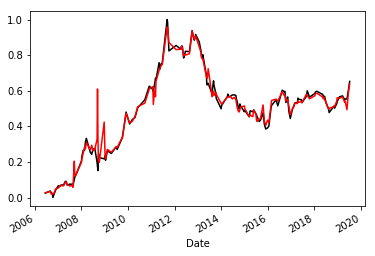

In [23]:
ax1 = y_test.plot(color="black")
ax2 = predictions[0].plot(color="red")

In [24]:
print('RMSE:', sqrt(mean_squared_error(y_test,predictions)))

RMSE: 0.04698229306850452


In [26]:
predictions_all = pd.DataFrame(RF_Model.predict(X),index=X.index)
predictions_all = pd.DataFrame(scaler_gold.inverse_transform(predictions_all),index=predictions_all.index)
predictions_all.columns = ["Relative Value"]
predictions_all = predictions_all.reset_index()
predictions_all["Date"] = predictions_all["Date"].apply(lambda x: x + timedelta(days=3))
predictions_all.tail()

,Date,Relative Value
680,2019-06-28,1378.192340
681,2019-07-05,1392.312565
682,2019-07-12,1387.177925
683,2019-07-19,1393.807609
684,2019-07-26,1388.131176


In [33]:
daily_transform_url = f"../data/csv/{metal}Prices.csv"
daily = pd.read_csv(daily_transform_url)[["Date","Settle"]]
daily["Date"] = pd.to_datetime(daily["Date"],infer_datetime_format=True)
daily = daily.merge(predictions_all,on="Date",how="left")
daily = daily.fillna(method="bfill")
daily = daily.dropna()
# daily.to_csv(f"../data/csv/{metal}_SVR_Daily.csv",index=False)
daily.tail(15)

,Date,Settle,Relative Value
3280,2006-07-10,626.1,603.749667
3281,2006-07-07,634.8,603.749667
3282,2006-07-06,636.3,587.669945
3283,2006-07-05,629.7,587.669945
3284,2006-06-30,616.0,587.669945
3285,2006-06-29,588.9,584.555691
3286,2006-06-28,578.3,584.555691
3287,2006-06-27,581.6,584.555691
3288,2006-06-26,584.8,584.555691
3289,2006-06-23,584.8,584.555691


In [32]:
# daily_transform_url = f"../data/csv/{metal}Prices.csv"
# daily = pd.read_csv(daily_transform_url)[["Date","Settle"]]
# daily["Date"] = pd.to_datetime(daily["Date"],infer_datetime_format=True)
# daily = daily.merge(predictions_all,on="Date",how="left")
# daily = daily.fillna(method="bfill")
# daily = daily.dropna()
# for i in range(len(daily.index)-3):
#     daily.at[i,"Relative Value"] = daily["Relative Value"][i+3]
# daily = daily.iloc[:len(daily.index)-3]
# # daily.to_csv(f"../data/csv/{metal}_RF_Daily.csv",index=False)
# daily.tail(15)

,Date,Settle,Relative Value
3277,2006-07-13,654.4,603.749667
3278,2006-07-12,651.2,603.749667
3279,2006-07-11,643.1,587.669945
3280,2006-07-10,626.1,587.669945
3281,2006-07-07,634.8,587.669945
3282,2006-07-06,636.3,584.555691
3283,2006-07-05,629.7,584.555691
3284,2006-06-30,616.0,584.555691
3285,2006-06-29,588.9,584.555691
3286,2006-06-28,578.3,584.555691


In [34]:
# only_fridays = [i for i in range(0,len(daily.index)+1,5)]
#weekly = daily.iloc[only_fridays]
#daily.to_csv(f"../data/csv/{metal}_RF_Weekly.csv",index=False)
#weekly.head()

#only_fridays = [i for i in range(0,len(FinalPredict_DF2.index)+1,5)]
#weekly = FinalPredict_DF2.iloc[only_fridays]
#weekly.head(10)

weekly = daily.loc[[True if day.weekday() == 4 else False for day in daily["Date"]]]
weekly.head()

,Date,Settle,Relative Value
3,2019-07-26,1419.3,1388.131176
8,2019-07-19,1426.7,1393.807609
13,2019-07-12,1412.2,1387.177925
18,2019-07-05,1400.1,1392.312565
22,2019-06-28,1413.7,1378.192340


C:\Users\benel\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\benel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sign
  """


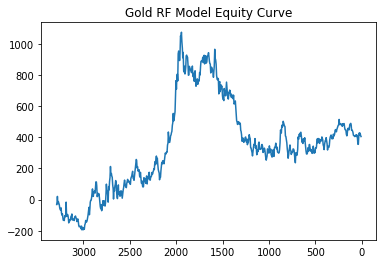

In [55]:
weekly.loc[:,'Settle Delta'] = weekly['Settle'].diff(+1)
weekly.loc[:,'Settle Delta'] = weekly['Settle Delta'].apply(lambda x:x*-1)
weekly.loc[:,'Rel Val Delta'] = weekly['Relative Value'].diff(-1)

Signal = np.sign(weekly['Rel Val Delta'])
weekly2 = pd.concat([weekly, pd.DataFrame(Signal)], axis=1)
weekly2.columns = ['Date', 'Settle', 'Relative Value', 'Settle Delta', 'Rel Val Delta', 'Signal']

weekly2['Profit'] = weekly2['Settle Delta']*weekly2['Signal']
weekly2['EC'] = weekly2.Profit[::-1].cumsum()
fig = plt.figure()
ax = weekly2['EC'].plot(title='Gold RF Model Equity Curve')
ax.invert_xaxis()
fig.savefig('../graphs/GOLD_RF.png')

In [56]:
weekly2

,Date,Settle,Relative Value,Settle Delta,Rel Val Delta,Signal,Profit,EC
3,2019-07-26,1419.3,1388.131176,NaN,-5.676433,-1.0,NaN,NaN
8,2019-07-19,1426.7,1393.807609,-7.4,6.629684,1.0,-7.4,405.1
13,2019-07-12,1412.2,1387.177925,14.5,-5.134640,-1.0,-14.5,412.5
18,2019-07-05,1400.1,1392.312565,12.1,14.120225,1.0,12.1,427.0
22,2019-06-28,1413.7,1378.192340,-13.6,57.998646,1.0,-13.6,414.9
27,2019-06-21,1396.2,1320.193694,17.5,0.485392,1.0,17.5,428.5
32,2019-06-14,1340.1,1319.708303,56.1,21.130772,1.0,56.1,411.0
37,2019-06-07,1341.2,1298.577531,-1.1,96.502698,1.0,-1.1,354.9
42,2019-05-31,1305.8,1202.074833,35.4,-75.235812,-1.0,-35.4,356.0
46,2019-05-24,1283.0,1277.310645,22.8,-14.969285,-1.0,-22.8,391.4


In [26]:
weekly2.to_csv(f"../data/csv/{metal}_FinalTable_RF.csv",index=False)